Segmentation and image prompting

In [38]:
# !pip install -U transformers
# !pip install -U datasets
# !pip install timm
# !pip install inflect
# !pip install phonemizer
# !pip install gradio
# !apt-get update && apt-get install -y espeak-ng
# !pip install py-espeak-ng
# !pip install torchvision

In [64]:
from transformers.utils import logging
logging.set_verbosity_error()
from transformers import pipeline
from datasets import load_dataset, load_from_disk
from IPython.display import Audio as IPythonAudio

import os
import gradio as gr
import io

Prepare the dataset of audio recordings

In [65]:
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

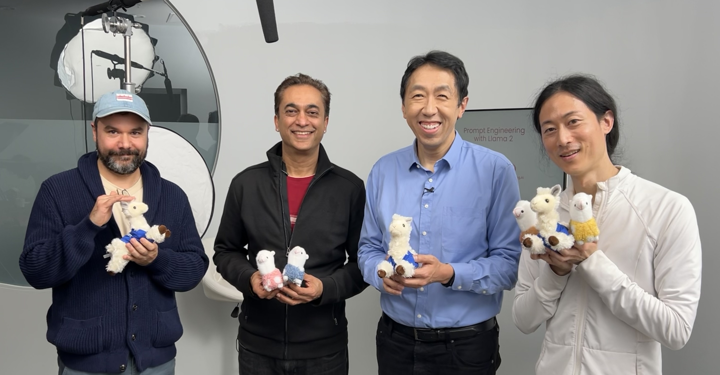

In [66]:
from PIL import Image
raw_image = Image.open('/content/meta_llamas.jpg')
raw_image.resize((720, 375))

In [42]:
output = sam_pipe(raw_image, points_per_batch=32)

In [43]:
from helper9 import show_pipe_masks_on_image

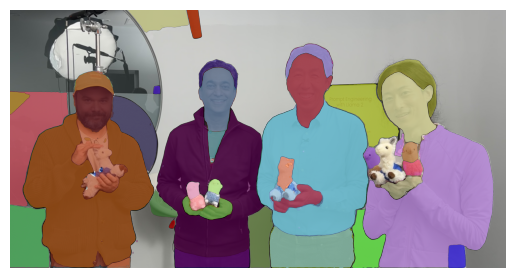

In [44]:
show_pipe_masks_on_image(raw_image, output)

Faster Inference: Infer an Image and a Single Point

In [45]:
from transformers import SamModel, SamProcessor

In [46]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

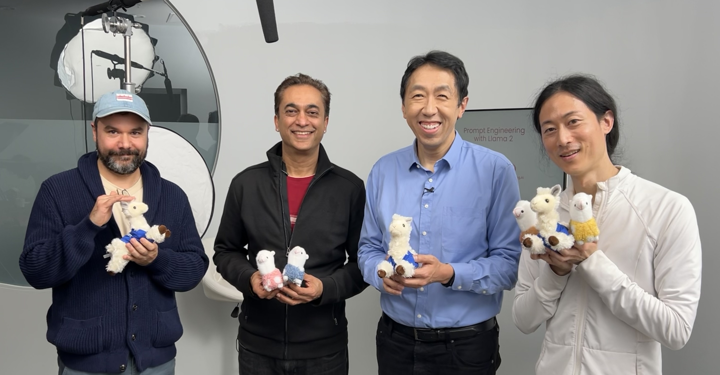

In [47]:
raw_image.resize((720, 375))

In [48]:
input_points = [[[1600, 700]]]

In [49]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

In [50]:
import torch

In [51]:
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [ ]:
len(predicted_masks)

In [ ]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

In [52]:
outputs.iou_scores

tensor([[[0.9583, 0.9551, 0.9580]]])

In [53]:
from helper9 import show_mask_on_image

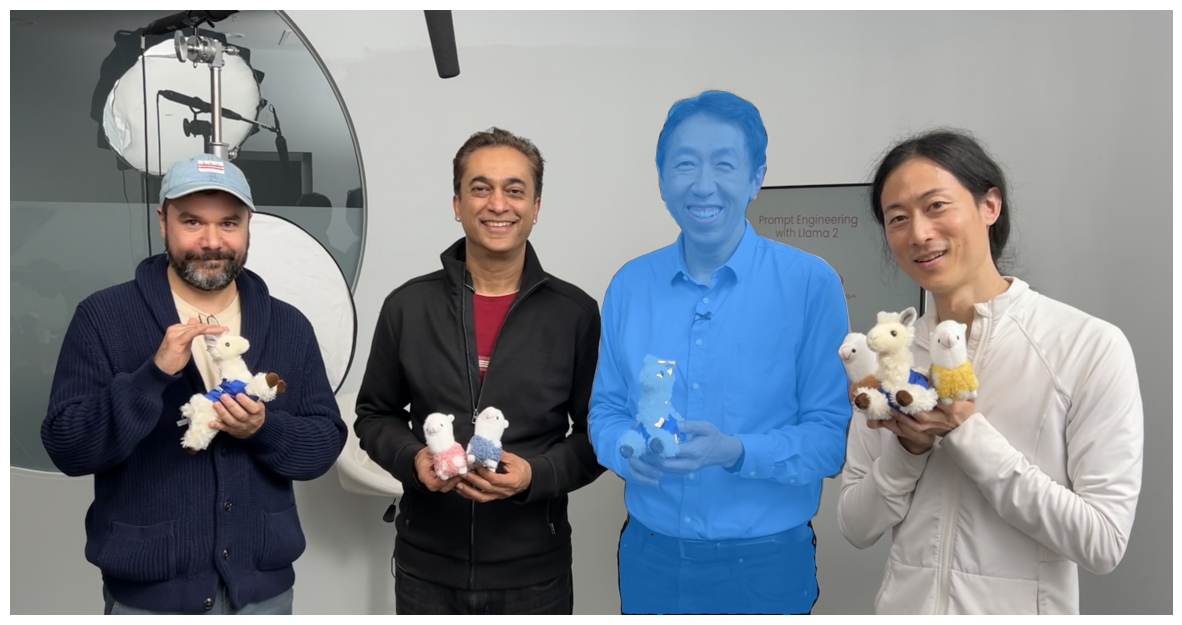

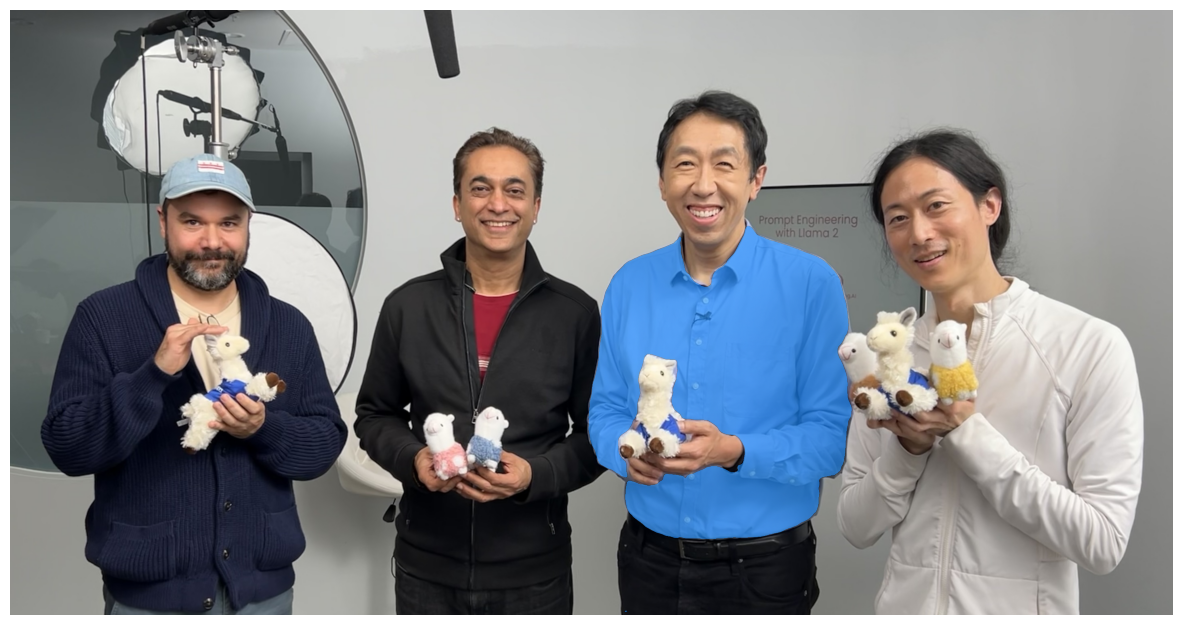

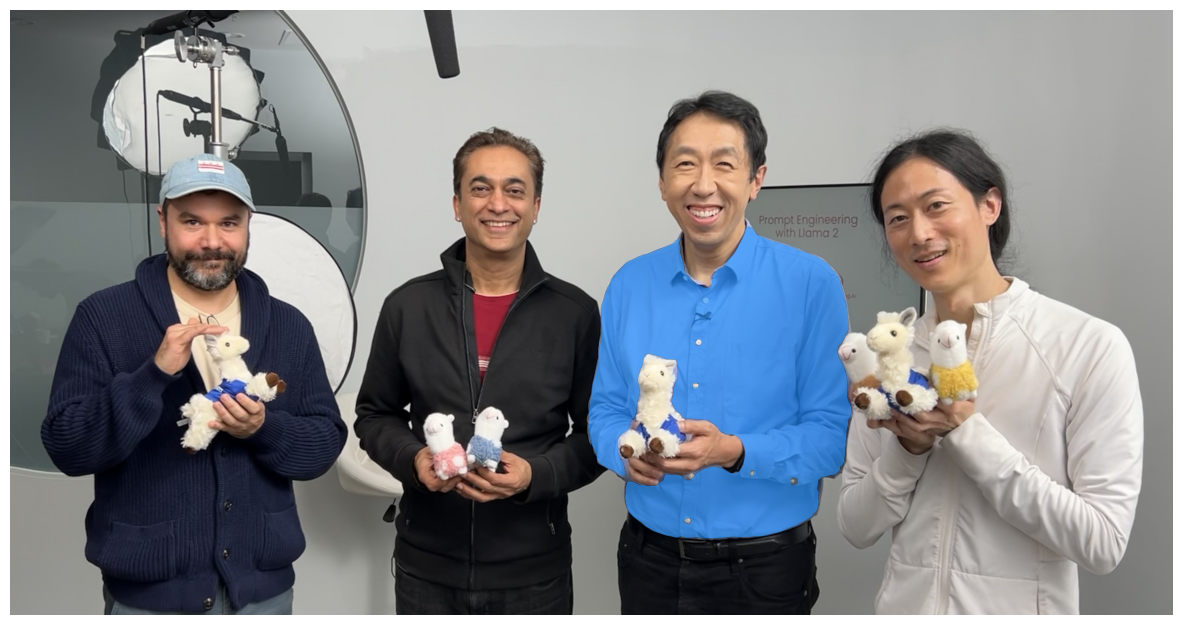

In [54]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

Depth Estimation with DPT
This model was introduced in the paper Vision Transformers for Dense Prediction by Ranftl et al. (2021) and first released in isl-org/DPT.

In [ ]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

In [ ]:
raw_image = Image.open('/content/gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

In [ ]:
output = depth_estimator(raw_image)

In [55]:
output

{'masks': [array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, 

In [ ]:
output["predicted_depth"].shape

In [ ]:
output["predicted_depth"].unsqueeze(1).shape

In [ ]:
# prediction = torch.nn.functional.interpolate(
#     output["predicted_depth"].unsqueeze(1),
#     size=raw_image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# Предполагая, что raw_image.size возвращает (ширину, высоту):
width, height = raw_image.size
depth_map = output["predicted_depth"]  # Исходный одномерный тензор глубины

# Преобразуем в двумерный вид, предполагая ширину × высоту
depth_map_reshaped = depth_map.view(height, width).unsqueeze(0).unsqueeze(0)  # Добавляем оси канала и батча

# Теперь делаем интерполяцию
prediction = torch.nn.functional.interpolate(
    depth_map_reshaped,
    size=(height, width),  # Вернуть обратно к оригинальной форме
    mode='bicubic',
    align_corners=False
)

In [ ]:
prediction.shape

In [56]:
raw_image.size[::-1],

((1500, 2880),)

In [57]:
import numpy as np

In [58]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

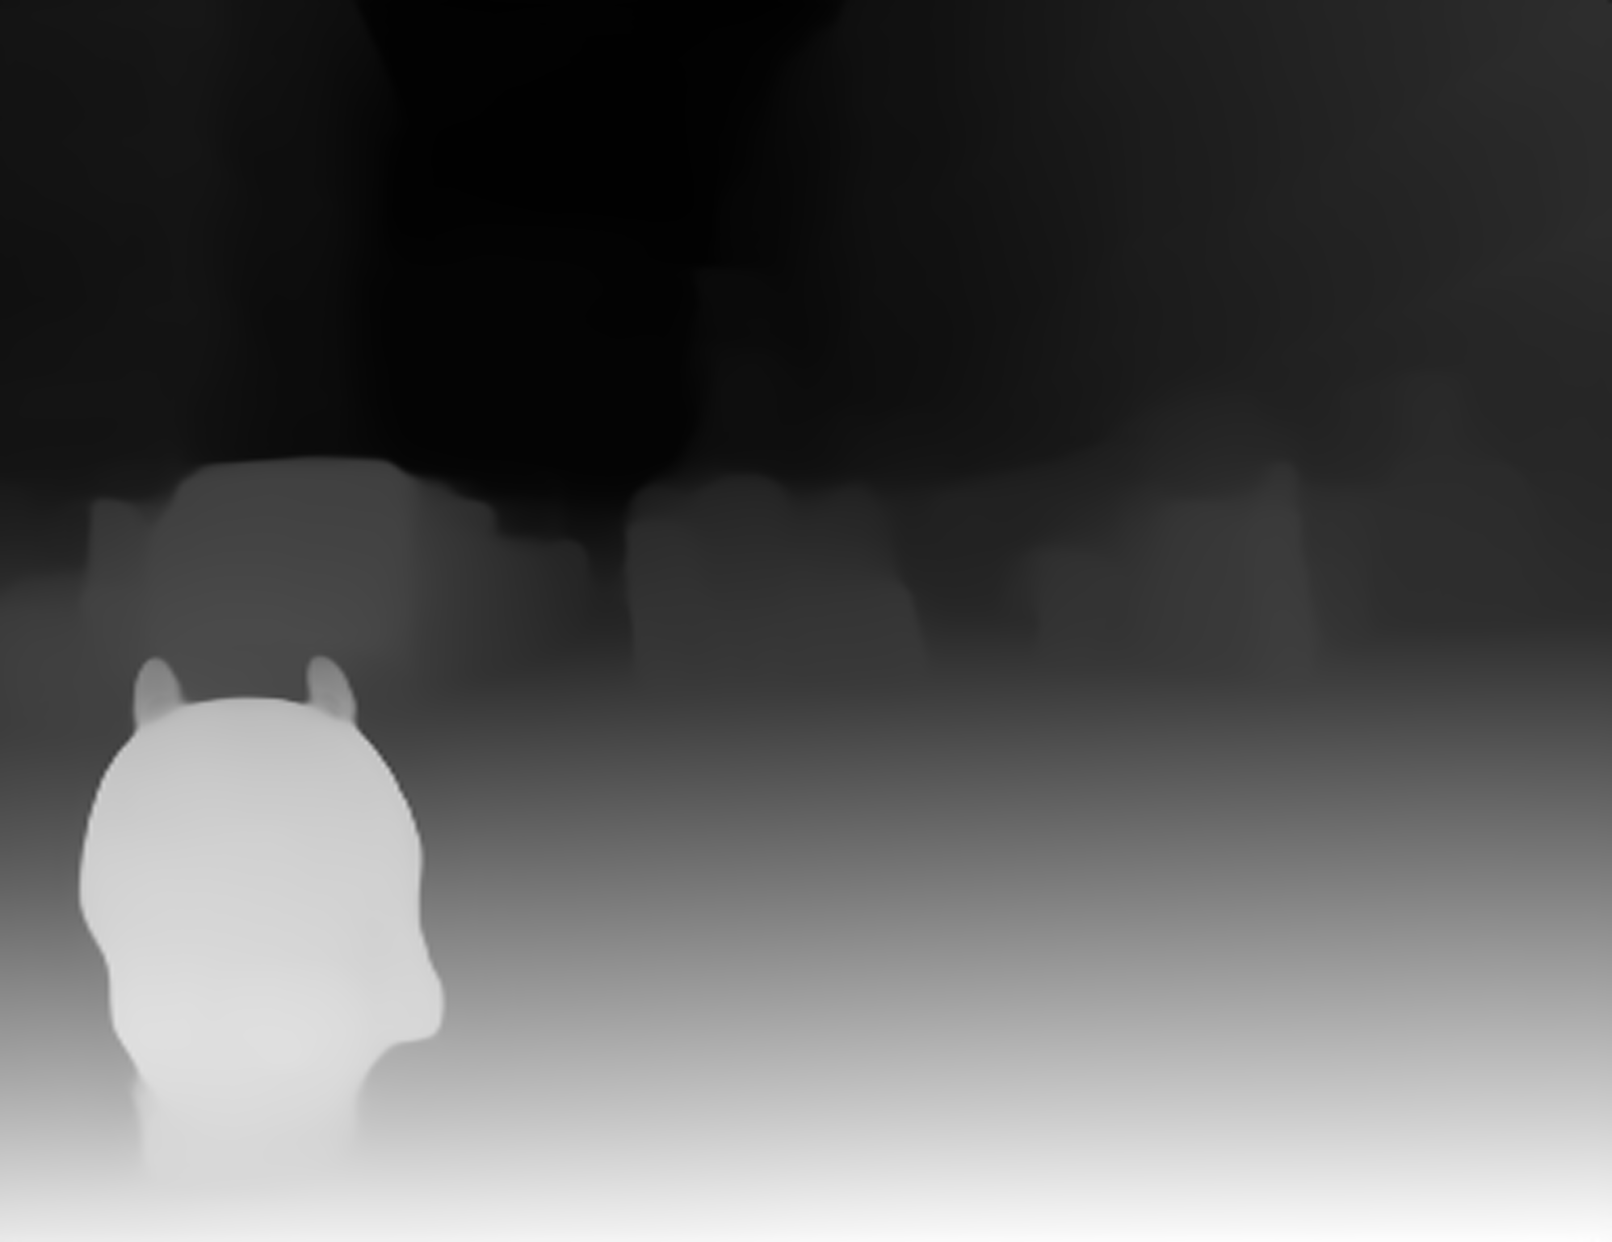

In [59]:
depth

In [60]:
import os
import gradio as gr
from transformers import pipeline

In [61]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [62]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs=gr.Image(type='pil'))

In [ ]:
iface.launch(share=True, server_port=3001)

In [63]:
# iface.close()